# Modeling Our Data Using Classification Methods

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# models
from sklearn import linear_model # logistic regression
from sklearn.linear_model import LogisticRegression

# hyper-parameter tuning and cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Modeling Our Data
1. Define the predictors and outcome
    - Decided to include all questions answered rather than an average over the questions for each scale. I would only want to use an average for the scales if I think that the coefficient for all the questions would be the same. It's possible that while the questions in these scales were designed to represent the same trait/behavior that some questions are more revealing of which group someone is in. if this is the case, then we would want to use all the individual questions as features rather than the averages. I'm just going to go ahead and include each individual question.
2. Perform any preprocessing necessary:
    - Convert features and outcome to numerical (0's and 1's)
3. Split into training and test sets
    - used a 70/30 split since our dataset is small
    - scaled the predictors after because that is often necessary for logistic regression
4. Define the classifiers I want to use
    - Decided on logistic regression because I am interested in including an interaction as a predictor in the model. Whil eother models can implicitly capture interactions, I want to compare a model without an interaction term to a model with an interction term. 
5. Perform hyper-parameter tuning using cross-validation on the training data to decide on the best model
    - Potentially penalize for number of predictors since our dataset is so small. Explain the penalty used.
    - Used accuracy to perform hyper-parameter tuning. Since the classes are fairly balanced and I'm not differentially concerned about false positives or false negatives, accuracy is a good metric to evaluate these models with. I want to see if it's possible for these models to produce accurate predictions of which condition someone was in, and it's ok if the model is slightly better at predicting that someone is in the in-group vs out-group for example.
6. Evaluate the performance of the best model chosen in the previous step on the test data
    - Ussed accuracy for the same reasons as above
    - Looked at confusion matrix
7. Determine feature importance to increase the interpretability of the model
    - Look at coefficients
    - Rank feature importance using shap

In [41]:
df = pd.read_csv('LP_dictator_cleaned.csv')

In [42]:
# checking out the columns available
df.columns

Index(['participantID', 'startDate', 'endDate', 'age', 'gender', 'self_disc',
       'priming_response', 'att_check', 'note', 'pt_1', 'pt_2', 'pt_3', 'pt_4',
       'pt_5', 'emp', 'dg', 'lp_scale_1_1', 'lp_scale_1_2', 'lp_scale_1_3',
       'lp_scale_1_4', 'lp_scale_1_5', 'lp_scale_1_6', 'lp_scale_1_7',
       'lp_scale_1_8', 'lp_scale_1_9', 'lp_scale_2_1', 'lp_scale_2_2',
       'lp_scale_2_3', 'lp_scale_2_4', 'lp_scale_2_5', 'att_check2',
       'lp_scale_2_7', 'lp_scale_2_8', 'includeOrExclude', 'priming_received',
       'inOrOut', 'condition', 'pt_1_reversed', 'pt_3_reversed',
       'pt_5_reversed', 'PT_avg', 'trait_learning_avg',
       'trait_performance_avg', 'avg_sentiment', 'words_with_sentiment',
       'first_person_pronoun_count', 'second_person_pronoun_count',
       'third_person_pronoun_count'],
      dtype='object')

In [54]:
# convert conditions to numbers to be used in models
group_class_names = np.array(['in', 'out']) # in = 0, out = 1
for i, name in zip(range(0,2), group_class_names):
    df.loc[df.inOrOut == name, 'inOrOut'] = i
priming_class_names = np.array(['performance', 'learning']) # performance = 0, learning = 1
for i, name in zip(range(0,2), priming_class_names):
    df.loc[df.priming_received == name, 'priming_received'] = i
gender_class_names = np.array(['male', 'female'])
for i, name in zip(range(0,2), gender_class_names):
    df.loc[df.gender == name, 'gender'] = i

### Classifying in-group and out-group
First I attempted to classify participants as in-group or out-group only using their responses to the questions about perspective taking, empathy, and altruism.

Best Parameters: {'C': 0.001, 'penalty': 'l1'}
pt_1: 0.0
pt_2: 0.0
pt_3: 0.0
pt_4: 0.0
pt_5: 0.0
emp: 0.0
dg: 0.0
Classification report for logistic regression:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        21
           1       0.00      0.00      0.00        17

    accuracy                           0.55        38
   macro avg       0.28      0.50      0.36        38
weighted avg       0.31      0.55      0.39        38



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


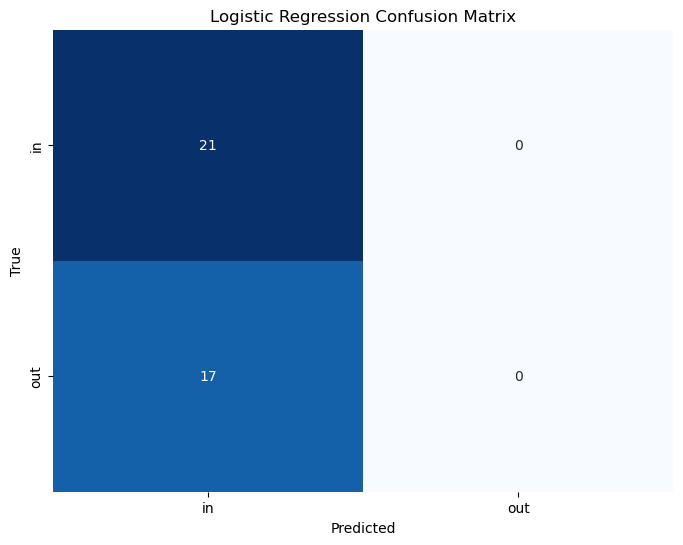

In [56]:
# logistic regression
# define the predictors and outcomes
X = np.array(df[['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg']]) # using all responses in case the slope is different for any one of them
y = np.array(pd.to_numeric(df['inOrOut']))

# split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=0) # setting a larger test size since we have such a small data set, random_state: get the same answer every time

# scale the X (best to do for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# tune the model using cross-validation on the training data
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring = 'accuracy') # using the liblinear solver because it's supposedly good for small datasets
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# fit the model using the best parameters
log_reg = LogisticRegression(C = .001, penalty = 'l1', solver='liblinear') # smaller values of C specify stronger regularization, L1 Regularization = lasso regression (removes unecssary coefficients)
log_reg.fit(X_train_scaled, y_train)
log_reg_predictions = log_reg.predict(X_test_scaled)

# print the coefficients
feature_names = ['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg']
coefs = log_reg.coef_[0]
coefs_w_names = list(zip(feature_names, coefs))
for feature, coefficient in coefs_w_names:
    print(f"{feature}: {coefficient}")

# evaluate
print('Classification report for logistic regression:')
print(classification_report(y_test, log_reg_predictions))

# confusion matrix
cm = confusion_matrix(y_test, log_reg_predictions)
# plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
           xticklabels=group_class_names, yticklabels=group_class_names)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# feature importance

### Classify priming received

Best Parameters: {'C': 1, 'penalty': 'l1'}
pt_1: 0.09130105113500078
pt_2: -0.21520770629846292
pt_3: -0.2176156641657952
pt_4: 0.0
pt_5: 0.0
emp: 0.6520669393796644
dg: -0.20269850225785732
Classification report for logistic regression:
              precision    recall  f1-score   support

           0       0.67      0.48      0.56        21
           1       0.52      0.71      0.60        17

    accuracy                           0.58        38
   macro avg       0.59      0.59      0.58        38
weighted avg       0.60      0.58      0.58        38



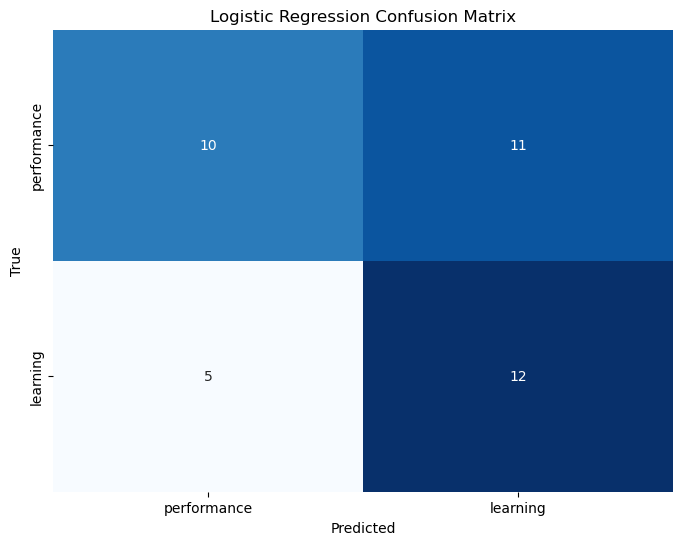

In [45]:
# logistic regression
# define the predictors and outcomes
X = np.array(df[['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg']]) # using all responses in case the slope is different for any one of them
y = np.array(pd.to_numeric(df['priming_received']))

# split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=0) # setting a larger test size since we have such a small data set, random_state: get the same answer every time

# scale the X (best to do for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# tune the model using cross-validation on the training data
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring = 'accuracy') # using the liblinear solver because it's supposedly good for small datasets
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# fit the model using the best parameters
log_reg = LogisticRegression(C = 1, penalty = 'l1', solver='liblinear') # smaller values of C specify stronger regularization, L1 Regularization = lasso regression (removes unecssary coefficients)
log_reg.fit(X_train_scaled, y_train)
log_reg_predictions = log_reg.predict(X_test_scaled)

# print the coefficients
feature_names = ['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg']
coefs = log_reg.coef_[0]
coefs_w_names = list(zip(feature_names, coefs))
for feature, coefficient in coefs_w_names:
    print(f"{feature}: {coefficient}")
    
# evaluate
print('Classification report for logistic regression:')
print(classification_report(y_test, log_reg_predictions))

# confusion matrix
cm = confusion_matrix(y_test, log_reg_predictions)
# plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
           xticklabels=priming_class_names, yticklabels=priming_class_names)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# feature importance

### Classifying in/out-group using priming received and trait-level orientation now
- There is likely an interaction between priming received and trait level orientation.
- Use logistic regression, input priming received, trait level orientation, and priming received x trait level orientation as predictors of in/out-group.
- Does this improve the classification of people in the in/out-group?
- Pull the slope of the interaction term

Best Parameters: {'C': 0.001, 'penalty': 'l1'}
pt_1: 0.0
pt_2: 0.0
pt_3: 0.0
pt_4: 0.0
pt_5: 0.0
emp: 0.0
dg: 0.0
priming_received: 0.0
trait_learning_avg: 0.0
priming_received*trait_learning_avg: 0.0
priming_received*trait_performance_avg: 0.0
Classification report for logistic regression:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        21
           1       0.00      0.00      0.00        17

    accuracy                           0.55        38
   macro avg       0.28      0.50      0.36        38
weighted avg       0.31      0.55      0.39        38



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


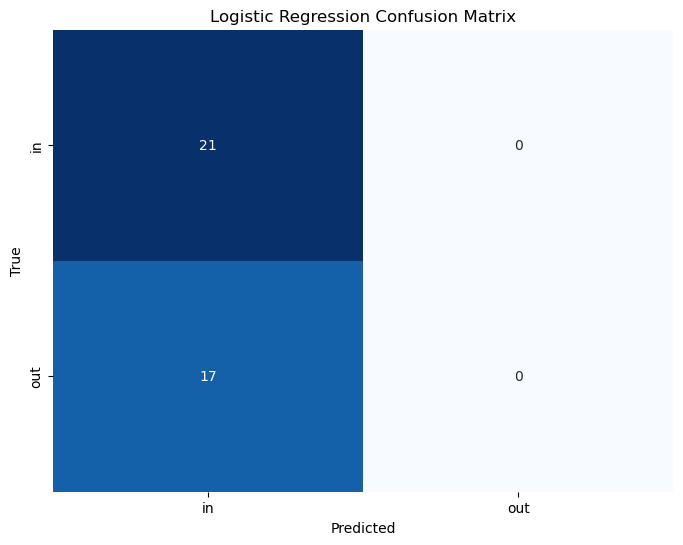

In [50]:
# logistic regression
# create interaction terms
df['priming_received*trait_learning_avg'] = df['priming_received'] * df['trait_learning_avg']
df['priming_received*trait_performance_avg'] = df['priming_received'] * df['trait_performance_avg']

# define the predictors and outcomes
X = np.array(df[['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg', 'priming_received', 'trait_learning_avg', 'priming_received*trait_learning_avg', 'priming_received*trait_performance_avg']]) # using all responses in case the slope is different for any one of them
y = np.array(pd.to_numeric(df['inOrOut']))

# split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=0) # setting a larger test size since we have such a small data set, random_state: get the same answer every time

# scale the X (best to do for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# tune the model using cross-validation on the training data
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring = 'accuracy') # using the liblinear solver because it's supposedly good for small datasets
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# fit the model using the best parameters
log_reg = LogisticRegression(C = .001, penalty = 'l1', solver='liblinear') # smaller values of C specify stronger regularization, L1 Regularization = lasso regression (removes unecssary coefficients)
log_reg.fit(X_train_scaled, y_train)
log_reg_predictions = log_reg.predict(X_test_scaled)

# print the coefficients
feature_names = ['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg', 'priming_received', 'trait_learning_avg', 'priming_received*trait_learning_avg', 'priming_received*trait_performance_avg']
coefs = log_reg.coef_[0]
coefs_w_names = list(zip(feature_names, coefs))
for feature, coefficient in coefs_w_names:
    print(f"{feature}: {coefficient}")

# evaluate
print('Classification report for logistic regression:')
print(classification_report(y_test, log_reg_predictions))

# confusion matrix
cm = confusion_matrix(y_test, log_reg_predictions)
# plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
           xticklabels=group_class_names, yticklabels=group_class_names)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Classifying in/out-group with the addition of sentiment and pronoun usage now

Best Parameters: {'C': 0.001, 'penalty': 'l1'}
pt_1: 0.0
pt_2: 0.0
pt_3: 0.0
pt_4: 0.0
pt_5: 0.0
emp: 0.0
dg: 0.0
priming_received: 0.0
trait_learning_avg: 0.0
priming_received*trait_learning_avg: 0.0
priming_received*trait_performance_avg: 0.0
avg_sentiment: 0.0
first_person_pronoun_count: 0.0
second_person_pronoun_count: 0.0
third_person_pronoun_count: 0.0
Classification report for logistic regression:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        21
           1       0.00      0.00      0.00        17

    accuracy                           0.55        38
   macro avg       0.28      0.50      0.36        38
weighted avg       0.31      0.55      0.39        38



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


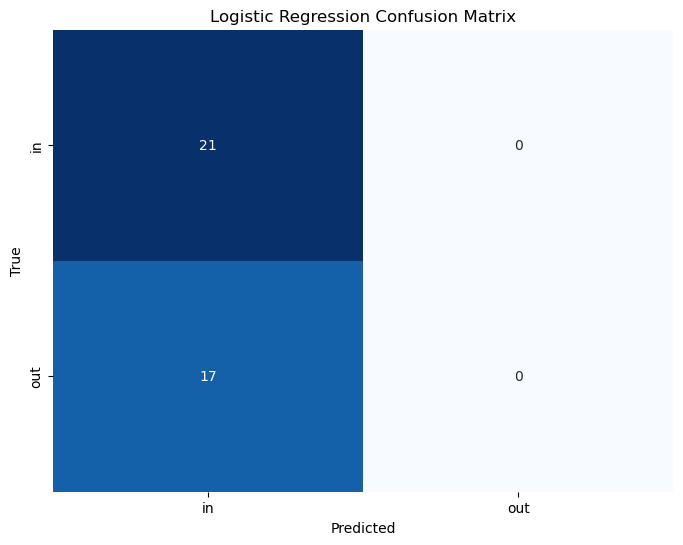

In [52]:
# logistic regression
# create interaction terms
df['priming_received*trait_learning_avg'] = df['priming_received'] * df['trait_learning_avg']
df['priming_received*trait_performance_avg'] = df['priming_received'] * df['trait_performance_avg']

# define the predictors and outcomes
X = np.array(df[['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg', 
                 'priming_received', 'trait_learning_avg', 'priming_received*trait_learning_avg', 'priming_received*trait_performance_avg',
                'avg_sentiment', 'first_person_pronoun_count', 'second_person_pronoun_count', 'third_person_pronoun_count']]) # using all responses in case the slope is different for any one of them
y = np.array(pd.to_numeric(df['inOrOut']))

# split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=0) # setting a larger test size since we have such a small data set, random_state: get the same answer every time

# scale the X (best to do for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# tune the model using cross-validation on the training data
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring = 'accuracy') # using the liblinear solver because it's supposedly good for small datasets
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# fit the model using the best parameters
log_reg = LogisticRegression(C = .001, penalty = 'l1', solver='liblinear') # smaller values of C specify stronger regularization, L1 Regularization = lasso regression (removes unecssary coefficients)
log_reg.fit(X_train_scaled, y_train)
log_reg_predictions = log_reg.predict(X_test_scaled)

# print the coefficients
feature_names = ['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg', 
                 'priming_received', 'trait_learning_avg', 'priming_received*trait_learning_avg', 'priming_received*trait_performance_avg',
                'avg_sentiment', 'first_person_pronoun_count', 'second_person_pronoun_count', 'third_person_pronoun_count']
coefs = log_reg.coef_[0]
coefs_w_names = list(zip(feature_names, coefs))
for feature, coefficient in coefs_w_names:
    print(f"{feature}: {coefficient}")

# evaluate
print('Classification report for logistic regression:')
print(classification_report(y_test, log_reg_predictions))

# confusion matrix
cm = confusion_matrix(y_test, log_reg_predictions)
# plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
           xticklabels=group_class_names, yticklabels=group_class_names)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Classifying Gender
Just went ahead and used the model with everything in it since I'm using a penalty for hte number of slopes included. Any slope that is not important

Best Parameters: {'C': 0.01, 'penalty': 'l2'}
pt_1: -0.08799569170414202
pt_2: -0.006428160486564562
pt_3: -0.05274145301235777
pt_4: 0.02883508614308693
pt_5: -0.06535246597531905
emp: 0.05315805944555659
dg: -0.002530809456457821
priming_received: 0.028868458076077772
trait_learning_avg: 0.01886456472705584
priming_received*trait_learning_avg: 0.039159215797960556
priming_received*trait_performance_avg: 0.0359234618834525
avg_sentiment: 0.05544552718222538
first_person_pronoun_count: -0.008341911462257351
second_person_pronoun_count: 0.0026335754748792487
third_person_pronoun_count: -0.01340553730388236
Classification report for logistic regression:
              precision    recall  f1-score   support

           0       0.53      0.50      0.51        18
           1       0.57      0.60      0.59        20

    accuracy                           0.55        38
   macro avg       0.55      0.55      0.55        38
weighted avg       0.55      0.55      0.55        38



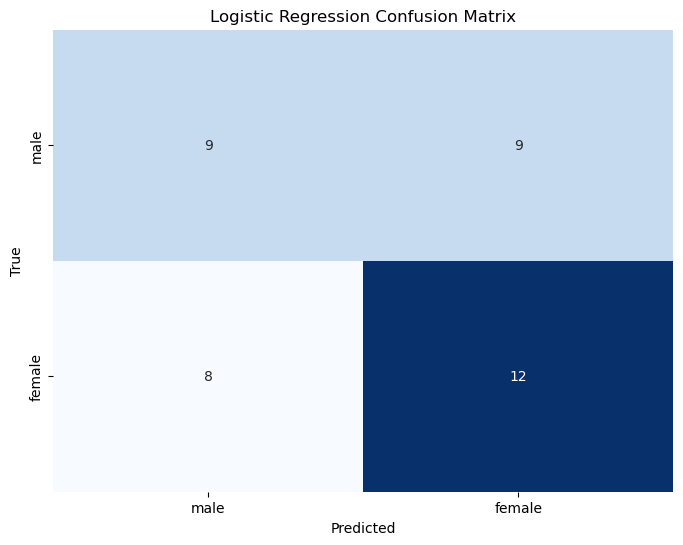

In [57]:
# logistic regression
# define the predictors and outcomes
X = np.array(df[['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg', 
                 'priming_received', 'trait_learning_avg', 'priming_received*trait_learning_avg', 'priming_received*trait_performance_avg',
                'avg_sentiment', 'first_person_pronoun_count', 'second_person_pronoun_count', 'third_person_pronoun_count']]) # using all responses in case the slope is different for any one of them
y = np.array(pd.to_numeric(df['gender']))

# split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=0) # setting a larger test size since we have such a small data set, random_state: get the same answer every time

# scale the X (best to do for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# tune the model using cross-validation on the training data
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring = 'accuracy') # using the liblinear solver because it's supposedly good for small datasets
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# fit the model using the best parameters
log_reg = LogisticRegression(C = .01, penalty = 'l2', solver='liblinear') # smaller values of C specify stronger regularization, L1 Regularization = lasso regression (removes unecssary coefficients)
log_reg.fit(X_train_scaled, y_train)
log_reg_predictions = log_reg.predict(X_test_scaled)

# print the coefficients
feature_names = ['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_5', 'emp', 'dg', 
                 'priming_received', 'trait_learning_avg', 'priming_received*trait_learning_avg', 'priming_received*trait_performance_avg',
                'avg_sentiment', 'first_person_pronoun_count', 'second_person_pronoun_count', 'third_person_pronoun_count']
coefs = log_reg.coef_[0]
coefs_w_names = list(zip(feature_names, coefs))
for feature, coefficient in coefs_w_names:
    print(f"{feature}: {coefficient}")

# evaluate
print('Classification report for logistic regression:')
print(classification_report(y_test, log_reg_predictions))

# confusion matrix
cm = confusion_matrix(y_test, log_reg_predictions)
# plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
           xticklabels=gender_class_names, yticklabels=gender_class_names)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Feature importance using shap (works on any classifier)
Look at a few points that were accurately classified and some that weren't
Can later do feature importance built into random forest and compare if I want